<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 ADDScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


<AxesSubplot: >

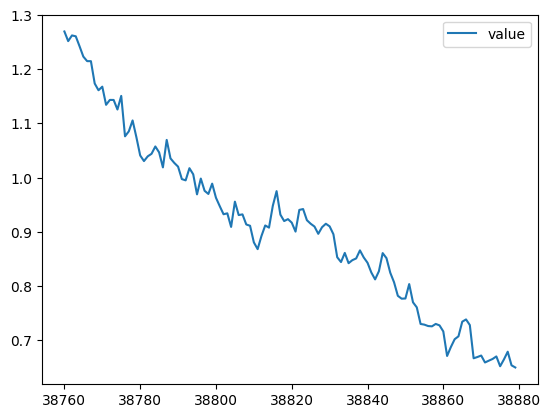

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584583/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 13.137888817323578 %
smape 10.09559636380066 %
smape 7.672468566319399 %
smape 5.487364761161002 %
smape 4.866117634456496 %
smape 4.54104539295604 %
smape 4.403975616911786 %
smape 4.2300334924625025 %
smape 4.260888032680541 %
smape 4.180105096709571 %
smape 4.150340735302334 %
smape 4.187809120896354 %
smape 4.065795055759406 %
smape 4.094839956317293 %
smape 4.066855648412691 %
smape 4.003279519959064 %
smape 4.083314857374855 %
smape 3.982630508859255 %
smape 3.9990375144134838 %
smape 3.9797258554625583 %
smape 3.9605878083285884 %
smape 3.966173352945966 %
smape 3.94584732495074 %
smape 3.9390696637463156 %
smape 3.9039751719029847 %
smape 3.931676595368319 %
smape 3.915434831328559 %
smape 3.9025818152429412 %
smape 3.8821341273271375 %
smape 3.914311153716163 %
smape 3.88164655730259 %
smape 3.892813991831496 %
smape 3.8417394884606026 %
smape 3.8810621215607863 %
smape 3.8474972775935776 %
smape 3.8740672111206234 %
smape 3.8260454596809996 %
smape 3.8594322238248173 %


In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.7152054578318712 %
SMAPE 1.4287644740943506 %
SMAPE 0.41915900336364587 %
SMAPE 0.44501570563716086 %
SMAPE 1.0521418425669253 %
SMAPE 0.24601222919227436 %
SMAPE 0.16587185410821803 %
SMAPE 0.20049668689898684 %
SMAPE 0.6344392412138404 %
SMAPE 0.374878917424212 %
SMAPE 0.4614479492447572 %
SMAPE 0.43077845854259067 %
SMAPE 0.6316086477060026 %
SMAPE 0.8945799065131723 %
SMAPE 0.20190319159519277 %
SMAPE 0.1460059707360415 %
SMAPE 0.3675937591215188 %
SMAPE 0.45934337689686794 %
SMAPE 0.341015501731988 %
SMAPE 0.14404720854508923 %
SMAPE 0.3820593270538666 %
SMAPE 0.8099439312190951 %
SMAPE 0.3755243125706329 %
SMAPE 0.9113635004177922 %
SMAPE 0.5094920373376226 %
SMAPE 0.7860383229344734 %
SMAPE 0.9380697832239094 %
SMAPE 0.359917735039744 %
SMAPE 0.5749023270664111 %
SMAPE 2.813092054813751 %
SMAPE 0.3280628616798822 %
SMAPE 0.2237867789717711 %
SMAPE 0.19308623018059734 %
SMAPE 0.28709767765303695 %
SMAPE 2.413412175108533 %
SMAPE 1.6957211975459359 %
SMAPE 0.58097325438848

SMAPE 0.1983989234740875 %
SMAPE 1.7758885316015949 %
SMAPE 0.27815289300451695 %
SMAPE 1.2273802044092008 %
SMAPE 0.503910905248631 %
SMAPE 0.2878866729006404 %
SMAPE 0.6062791349195322 %
SMAPE 1.4981910349160898 %
SMAPE 0.670457033053026 %
SMAPE 0.14655211184890504 %
SMAPE 0.09072372767604975 %
SMAPE 0.21543376435784012 %
SMAPE 2.4906967721590263 %
SMAPE 0.7385181202334934 %
SMAPE 0.2004170346427827 %
SMAPE 0.20465633123421867 %
SMAPE 1.002751654596068 %
SMAPE 1.7849122289189838 %
SMAPE 2.044212321247869 %
SMAPE 0.6245650373675744 %
SMAPE 0.07481410944524214 %
SMAPE 1.0938647468665295 %
SMAPE 0.8371974085694092 %
SMAPE 0.06540946358745714 %
SMAPE 1.6524080650196993 %
SMAPE 0.9200764556389913 %
SMAPE 1.034098970310879 %
SMAPE 1.9384158920402115 %
SMAPE 1.5688861163107506 %
SMAPE 1.077365110963001 %
SMAPE 0.3364517827786102 %
SMAPE 0.9898870676406659 %
SMAPE 0.9251440015868867 %
SMAPE 0.0971278416691348 %
SMAPE 0.9351428379710569 %
SMAPE 0.294309394700349 %
SMAPE 1.2715807521453826 %
S

SMAPE 0.4131899190288096 %
SMAPE 0.22069991347484574 %
SMAPE 0.011111360667428016 %
SMAPE 0.1948679595888052 %
SMAPE 0.1769995500224013 %
SMAPE 0.05113485347146707 %
SMAPE 0.06466343172837696 %
SMAPE 0.0842088545068691 %
SMAPE 0.42123507729866105 %
SMAPE 0.022020392779722897 %
SMAPE 0.4799679315483445 %
SMAPE 0.18830916075595638 %
SMAPE 0.008167041334218084 %
SMAPE 0.35826329697033543 %
SMAPE 0.11215851997599202 %
SMAPE 0.171693188034169 %
SMAPE 0.05031577161321365 %
SMAPE 0.3628413728046951 %
SMAPE 0.0668865158041072 %
SMAPE 0.033399487686551765 %
SMAPE 0.08921858917119607 %
SMAPE 0.11111557621234168 %
SMAPE 0.13527033413652134 %
SMAPE 0.1329499506441607 %
SMAPE 0.10264827998025794 %
SMAPE 0.10688036158694558 %
SMAPE 0.5275631723839069 %
SMAPE 0.7199152092191525 %
SMAPE 0.11124848466806726 %
SMAPE 0.16929699046556834 %
SMAPE 0.06108560774887196 %
SMAPE 0.19761207691382765 %
SMAPE 0.16794053970897949 %
SMAPE 0.40513777567957726 %
SMAPE 0.08952703946090423 %
SMAPE 0.21526397956616708 %


SMAPE 0.016718541847502877 %
SMAPE 0.15623829739888606 %
SMAPE 0.10794944598501387 %
SMAPE 0.1764129636854932 %
SMAPE 0.11602125056708701 %
SMAPE 0.2710064860696093 %
SMAPE 0.10569136942243064 %
SMAPE 0.21791513691087516 %
SMAPE 0.020998718118107718 %
SMAPE 0.037054910177744205 %
SMAPE 0.7034541559805803 %
SMAPE 0.01693864474327711 %
SMAPE 0.3984657540368062 %
SMAPE 0.007079339923244277 %
SMAPE 0.03437890446321035 %
SMAPE 0.13148406891400555 %
SMAPE 0.29462095458740123 %
SMAPE 0.04630643354857966 %
SMAPE 0.5590292595834399 %
SMAPE 0.12333393771996269 %
SMAPE 0.01724279015229513 %
SMAPE 0.3441460029342238 %
SMAPE 0.10310971614035225 %
SMAPE 0.4579365964564204 %
SMAPE 0.06425867452435341 %
SMAPE 0.06834736008659092 %
SMAPE 0.047901423433700074 %
SMAPE 0.16834923982014516 %
SMAPE 0.10334968862355254 %
SMAPE 0.013473607586035994 %
SMAPE 0.10858412945708551 %
SMAPE 0.3835847179288976 %
SMAPE 0.06220723802402973 %
SMAPE 0.33754679564890466 %
SMAPE 0.04303284114848793 %
SMAPE 0.09904368802261

SMAPE 0.03376415170828295 %
SMAPE 0.05377979263334964 %
SMAPE 0.00917613229808012 %
SMAPE 0.12866204708643636 %
SMAPE 0.249683649215342 %
SMAPE 0.21996316631458512 %
SMAPE 0.6168105720353196 %
SMAPE 0.25192665632584976 %
SMAPE 1.378007157076354 %
SMAPE 0.062065161206135144 %
SMAPE 0.09442567249868716 %
SMAPE 1.3554847439754667 %
SMAPE 0.07675358906834617 %
SMAPE 0.1359293364766927 %
SMAPE 0.03782961873912427 %
SMAPE 0.04965578805922633 %
SMAPE 0.8350550715913414 %
SMAPE 0.09818137013689919 %
SMAPE 0.09897979331526587 %
SMAPE 0.1961542187791565 %
SMAPE 0.10426022619162723 %
SMAPE 0.16997905876553432 %
SMAPE 0.517149626220089 %
SMAPE 0.22547392145133927 %
SMAPE 0.7040159082343962 %
SMAPE 0.03561214663426426 %
SMAPE 0.2538090684047347 %
SMAPE 0.02241441682016898 %
SMAPE 0.16874478861598163 %
SMAPE 0.3236278576632685 %
SMAPE 0.1747372948721022 %
SMAPE 0.28235829889035813 %
SMAPE 0.1755479773000843 %
SMAPE 0.21767820409331762 %
SMAPE 0.36117704734567724 %
SMAPE 0.1105989853290339 %
SMAPE 0.

SMAPE 0.5212176182712938 %
SMAPE 0.8914395072897605 %
SMAPE 0.8739174513721082 %
SMAPE 0.7623353603485157 %
SMAPE 0.7058708994695735 %
SMAPE 1.2934985157444316 %
SMAPE 0.9044084923407353 %
SMAPE 0.18701875140732227 %
SMAPE 0.02814663905371617 %
SMAPE 0.4213702599427052 %
SMAPE 0.5482764258149473 %
SMAPE 0.6009269889236748 %
SMAPE 0.3871639672627225 %
SMAPE 0.02922664963273291 %
SMAPE 0.18312543011734306 %
SMAPE 0.04431337326695939 %
SMAPE 0.06523623330394912 %
SMAPE 1.3859361987506418 %
SMAPE 0.26938035012426553 %
SMAPE 0.19108437586169202 %
SMAPE 0.7347568968689302 %
SMAPE 0.5919609012045726 %
SMAPE 0.7037910942817689 %
SMAPE 0.3867156754313328 %
SMAPE 0.48857369582526644 %
SMAPE 0.36709498002073815 %
SMAPE 0.1079526057487783 %
SMAPE 0.8045011307441997 %
SMAPE 0.4041544575984517 %
SMAPE 1.2974449374351025 %
SMAPE 0.9644414204594797 %
SMAPE 0.1054298873598327 %
SMAPE 0.07612639756405315 %
SMAPE 0.19844759052102748 %
SMAPE 0.051402425205651525 %
SMAPE 0.3666802245402323 %
SMAPE 1.298446

SMAPE 0.7349601487148902 %
SMAPE 0.44785096930559126 %
SMAPE 0.059481242953097535 %
SMAPE 0.09784414883506543 %
SMAPE 0.19845527235156624 %
SMAPE 0.7459034963467275 %
SMAPE 0.08852173073682934 %
SMAPE 0.3372020512179006 %
SMAPE 0.6536940476012205 %
SMAPE 0.5190125201866067 %
SMAPE 0.682177819743174 %
SMAPE 0.21381138179276607 %
SMAPE 2.7335687048152977 %
SMAPE 0.3901661984182283 %
SMAPE 0.42455776240103665 %
SMAPE 0.02872244305831373 %
SMAPE 0.06443286865760456 %
SMAPE 0.23953813541356794 %
SMAPE 0.6380342277207092 %
SMAPE 0.08119888230862671 %
SMAPE 0.23383037858684474 %
SMAPE 1.9236021664810323 %
SMAPE 0.2531559349490635 %
SMAPE 0.13699213441122993 %
SMAPE 1.4057914206841815 %
SMAPE 0.033096596838731784 %
SMAPE 0.10301634988718433 %
SMAPE 0.06829362713068576 %
SMAPE 0.24730084714065015 %
SMAPE 0.23412717522546697 %
SMAPE 0.25700052266438433 %
SMAPE 1.0228354602475065 %
SMAPE 0.22485037435910726 %
SMAPE 2.610323476328631 %
SMAPE 0.48479015489374433 %
SMAPE 0.042209726431224226 %
SMAPE

SMAPE 0.09810899047687373 %
SMAPE 0.05460574167818776 %
SMAPE 0.23539538050192732 %
SMAPE 0.005544411282244255 %
SMAPE 0.015540008691459663 %
SMAPE 0.17998992821821957 %
SMAPE 0.006552113126303993 %
SMAPE 0.09662379574092483 %
SMAPE 0.20471816727496164 %
SMAPE 0.06736220108405178 %
SMAPE 0.44284650813824555 %
SMAPE 0.5498235219802154 %
SMAPE 0.04601993406413385 %
SMAPE 0.05712309396437832 %
SMAPE 0.01872625556705998 %
SMAPE 0.1988833971627173 %
SMAPE 0.026588829990373593 %
SMAPE 0.4752272138409808 %
SMAPE 0.2512396046521417 %
SMAPE 0.019956359256866563 %
SMAPE 0.1287549710358178 %
SMAPE 0.021836131319901142 %
SMAPE 0.230490771382847 %
SMAPE 0.08495102646907071 %
SMAPE 0.010421494300317136 %
SMAPE 0.13241469311458332 %
SMAPE 0.7509714739535411 %
SMAPE 0.3313152218843243 %
SMAPE 0.08146850299954167 %
SMAPE 0.031090900232996436 %
SMAPE 0.0431532038568605 %
SMAPE 0.01653137886512468 %
SMAPE 0.021014373403204445 %
SMAPE 0.01448603804283266 %
SMAPE 0.08964247142966997 %
SMAPE 0.1995135722791

SMAPE 0.26110463296157604 %
SMAPE 0.008113401691275612 %
SMAPE 0.13586652447747838 %
SMAPE 0.18545753793114272 %
SMAPE 0.3360955035981874 %
SMAPE 0.39078967575369467 %
SMAPE 0.028210307196104626 %
SMAPE 0.26567484011275155 %
SMAPE 0.13713437305978005 %
SMAPE 0.29556507530148934 %
SMAPE 0.05894845209513732 %
SMAPE 0.2749299323459127 %
SMAPE 0.24374935135756456 %
SMAPE 0.03101525135633665 %
SMAPE 0.005683148847282382 %
SMAPE 0.06272364592439317 %
SMAPE 0.3805403407211543 %
SMAPE 0.005316140053764684 %
SMAPE 0.007536574936011674 %
SMAPE 0.6917322911394876 %
SMAPE 0.45126259838662003 %
SMAPE 0.10817065620085486 %
SMAPE 0.16179989646752801 %
SMAPE 0.2715520487736285 %
SMAPE 0.02506481433857033 %
SMAPE 0.07399275326493182 %
SMAPE 0.026778241265674296 %
SMAPE 0.05987697939435321 %
SMAPE 0.18119867033146875 %
SMAPE 0.027904965919788083 %
SMAPE 0.22269600677100243 %
SMAPE 0.14033917204193358 %
SMAPE 0.30220633860457724 %
SMAPE 0.16288959561485683 %
SMAPE 0.11120191726217854 %
SMAPE 0.1081664123

SMAPE 0.09039574207122314 %
SMAPE 0.4965881648067807 %
SMAPE 1.5707273972257099 %
SMAPE 0.11779349195307985 %
SMAPE 0.017246784518647473 %
SMAPE 0.03801044677675236 %
SMAPE 0.041090931503276806 %
SMAPE 0.6326090594193374 %
SMAPE 0.19528657140904215 %
SMAPE 0.040408385446198736 %
SMAPE 0.05253979649660324 %
SMAPE 0.4168499024881384 %
SMAPE 0.03869138826860308 %
SMAPE 0.3297799934016439 %
SMAPE 0.3680582773056358 %
SMAPE 0.2205377559025692 %
SMAPE 0.06293813561785555 %
SMAPE 0.22526789111179824 %
SMAPE 0.37524302987108626 %
SMAPE 0.07696214506722754 %
SMAPE 0.19247073347776222 %
SMAPE 0.047990311318507395 %
SMAPE 0.009129163710895227 %
SMAPE 0.3635016638669555 %
SMAPE 0.008523942238781501 %
SMAPE 0.06969287129868462 %
SMAPE 0.07354771157645246 %
SMAPE 0.07840561710162319 %
SMAPE 0.6907302963344932 %
SMAPE 0.12433028186842421 %
SMAPE 0.6306475920755474 %
SMAPE 0.6665139008158576 %
SMAPE 0.20592122500556798 %
SMAPE 0.21327904404674314 %
SMAPE 0.2639490063043368 %
SMAPE 0.8694323962736235 %

SMAPE 0.10444168116009676 %
SMAPE 0.06595789113771389 %
SMAPE 1.0469500532360598 %
SMAPE 0.6501929122775891 %
SMAPE 0.42604790209225024 %
SMAPE 3.9371346225379966 %
SMAPE 0.12198752065251028 %
SMAPE 0.2628909747036232 %
SMAPE 0.08543298690199208 %
SMAPE 0.40357687158711997 %
SMAPE 0.07458833467171644 %
SMAPE 0.07031665335898651 %
SMAPE 1.275725530910222 %
SMAPE 0.8257044838028378 %
SMAPE 1.3940187306664598 %
SMAPE 1.3686084348737495 %
SMAPE 0.6871322443603276 %
SMAPE 0.20673782984340505 %
SMAPE 2.1766482789953443 %
SMAPE 0.26181526483765083 %
SMAPE 0.9923687477203202 %
SMAPE 2.04938296952605 %
SMAPE 2.0389410982334084 %
SMAPE 0.05627799339686135 %
SMAPE 0.8792718571203294 %
SMAPE 0.373852372104011 %
SMAPE 0.37365703800423944 %
SMAPE 1.567637026153534 %
SMAPE 0.5212383607158699 %
SMAPE 3.075459843712906 %
SMAPE 0.21291620709689593 %
SMAPE 0.17095200388030207 %
SMAPE 1.1500190828701307 %
SMAPE 1.501929553054083 %
SMAPE 0.7181744952749796 %
SMAPE 0.8952365681643641 %
SMAPE 0.2647276442921

SMAPE 0.04013749765272223 %
SMAPE 0.5356983604251582 %
SMAPE 0.936173508450338 %
SMAPE 0.05306271761173775 %
SMAPE 0.049400472077024915 %
SMAPE 0.04444665323535446 %
SMAPE 0.23324802236220418 %
SMAPE 0.13694916064696372 %
SMAPE 0.2101807415174335 %
SMAPE 0.03685354588333212 %
SMAPE 0.6257191649424954 %
SMAPE 0.6917495762327235 %
SMAPE 0.025113462241506568 %
SMAPE 0.014176772755490672 %
SMAPE 0.055430280309906266 %
SMAPE 0.14363937336156596 %
SMAPE 1.2325933826705295 %
SMAPE 0.9497463189491099 %
SMAPE 0.06917353361212264 %
SMAPE 0.6332119635526396 %
SMAPE 0.009675322373112749 %
SMAPE 0.576540555950487 %
SMAPE 0.19433161627057416 %
SMAPE 0.9923260572813888 %
SMAPE 0.19975477107345793 %
SMAPE 0.35624978324131007 %
SMAPE 2.834098427905701 %
SMAPE 2.0663984410571175 %
SMAPE 0.40678918079629517 %
SMAPE 0.3912927766491521 %
SMAPE 0.3395126900286414 %
SMAPE 1.06325244822483 %
SMAPE 2.1145670158512075 %
SMAPE 1.6231969352634223 %
SMAPE 1.6650070753021284 %
SMAPE 0.10099429088836587 %
SMAPE 0.10

SMAPE 0.45280522564644343 %
SMAPE 0.25292415281961667 %
SMAPE 0.011460363742571644 %
SMAPE 0.2408310392556814 %
SMAPE 0.2101825360998646 %
SMAPE 0.14637425460932718 %
SMAPE 0.25963508374323396 %
SMAPE 0.05018041139248908 %
SMAPE 0.13468276517119193 %
SMAPE 0.05821511518229272 %
SMAPE 0.05022445738018178 %
SMAPE 0.4203837048855803 %
SMAPE 2.201895415695617 %
SMAPE 0.16267480074566265 %
SMAPE 0.13202680876491968 %
SMAPE 0.01564588098301556 %
SMAPE 0.41228946258775073 %
SMAPE 0.09638277731272638 %
SMAPE 0.2205423347904798 %
SMAPE 0.21060372791907866 %
SMAPE 0.13177272574216659 %
SMAPE 0.3611129156033712 %
SMAPE 0.07777210623726205 %
SMAPE 0.05859239010180772 %
SMAPE 0.11442826867596523 %
SMAPE 0.20837701400523656 %
SMAPE 0.012375995839562394 %
SMAPE 0.06551912395798354 %
SMAPE 0.36087577708167373 %
SMAPE 0.014537244538587402 %
SMAPE 0.18854498018731647 %
SMAPE 0.3821629421034345 %
SMAPE 0.819488371573243 %
SMAPE 0.00947067251399858 %
SMAPE 0.05953976872642386 %
SMAPE 0.03847367927562573 %

SMAPE 0.36133965076032837 %
SMAPE 0.09298731594441279 %
SMAPE 0.09493641366361771 %
SMAPE 0.044250449820765425 %
SMAPE 0.17269129761007207 %
SMAPE 0.055343359227663314 %
SMAPE 0.048848939096842514 %
SMAPE 0.006743575481365838 %
SMAPE 0.21726766283700272 %
SMAPE 0.016350689211321878 %
SMAPE 0.22264663146358996 %
SMAPE 0.46237319863848825 %
SMAPE 0.13649665692264534 %
SMAPE 0.050816582930565346 %
SMAPE 0.06684246044744668 %
SMAPE 0.343504601509494 %
SMAPE 0.9151854301508137 %
SMAPE 0.4400487558707482 %
SMAPE 0.5389717629186634 %
SMAPE 0.09324209953047102 %
SMAPE 0.38271183757763083 %
SMAPE 0.3550897299560347 %
SMAPE 0.018676702507093523 %
SMAPE 0.04514267899230617 %
SMAPE 0.2523822984439903 %
SMAPE 0.382083631878686 %
SMAPE 0.24239856544136273 %
SMAPE 0.17200574914659228 %
SMAPE 0.06933001352950896 %
SMAPE 0.13299478608723803 %
SMAPE 0.9760211102111498 %
SMAPE 0.2384517628379399 %
SMAPE 0.5273350536542694 %
SMAPE 0.054295452116093657 %
SMAPE 0.6510193703334153 %
SMAPE 0.8107902398255645 

SMAPE 0.13655063239772858 %
SMAPE 0.28115016964875394 %
SMAPE 0.11751965414021014 %
SMAPE 0.008826965858759195 %
SMAPE 0.21578995601362294 %
SMAPE 0.9097063866438475 %
SMAPE 0.15314117507980995 %
SMAPE 0.1175543153990475 %
SMAPE 0.2765513853366883 %
SMAPE 0.505569636336304 %
SMAPE 0.9406501066991949 %
SMAPE 0.3473868027485878 %
SMAPE 0.09688443385130086 %
SMAPE 0.07990839584579135 %
SMAPE 0.8698303188270983 %
SMAPE 0.3322956596230142 %
SMAPE 0.1865433925668185 %
SMAPE 0.008715928058684597 %
SMAPE 0.11864710306713278 %
SMAPE 0.21083317199588691 %
SMAPE 0.5572889268530616 %
SMAPE 0.026511318647976623 %
SMAPE 0.09645833673243942 %
SMAPE 0.030486451631546174 %
SMAPE 0.45123739943301194 %
SMAPE 0.16213292805014135 %
SMAPE 0.2786582573269243 %
SMAPE 0.01909353587439 %
SMAPE 0.02724312624502545 %
SMAPE 0.08149531501453566 %
SMAPE 0.1270146648992636 %
SMAPE 0.7231863175293256 %
SMAPE 0.03994907308415918 %
SMAPE 0.23259398358641192 %
SMAPE 0.32559773664070235 %
SMAPE 1.2802854824603855 %
SMAPE 

SMAPE 0.7252100503046677 %
SMAPE 0.42851637248077173 %
SMAPE 1.4851968006514653 %
SMAPE 1.3777244513744336 %
SMAPE 0.4506297879779595 %
SMAPE 0.9026571803042316 %
SMAPE 1.1189240191451972 %
SMAPE 1.0387006638848106 %
SMAPE 0.17867275018761575 %
SMAPE 0.45294620084314374 %
SMAPE 0.5704984614912973 %
SMAPE 0.17795638868324204 %
SMAPE 3.083956326270709 %
SMAPE 0.07341128223424676 %
SMAPE 0.5837771199443296 %
SMAPE 0.5401472584635485 %
SMAPE 0.8318908670626115 %
SMAPE 0.36446965054983593 %
SMAPE 0.3303815244889847 %
SMAPE 0.08274031766632106 %
SMAPE 0.17817039572037174 %
SMAPE 0.6653510436790384 %
SMAPE 2.0565947856157436 %
SMAPE 0.7705956438003341 %
SMAPE 0.6513515757251298 %
SMAPE 0.977968485567544 %
SMAPE 0.014617193467415747 %
SMAPE 0.7926210934747359 %
SMAPE 1.74598671923377 %
SMAPE 0.5681512620903959 %
SMAPE 0.346778615614312 %
SMAPE 0.7055214624288055 %
SMAPE 0.9684458792235092 %
SMAPE 0.5845278750264242 %
SMAPE 0.3768182171161243 %
SMAPE 1.1406323809733294 %
SMAPE 0.077536013253848

SMAPE 0.12750728314244952 %
SMAPE 0.2272210598671336 %
SMAPE 0.10439636444607459 %
SMAPE 0.3317961340171678 %
SMAPE 0.1946957379941523 %
SMAPE 0.07270164064402707 %
SMAPE 0.04438981080602389 %
SMAPE 0.4273292864281757 %
SMAPE 0.32557885889502813 %
SMAPE 0.208623421693801 %
SMAPE 0.07853819206505364 %
SMAPE 0.03190171739788639 %
SMAPE 0.02516707596601009 %
SMAPE 0.4416525172423462 %
SMAPE 0.2600144400548743 %
SMAPE 0.08490939932892161 %
SMAPE 0.027229690923149977 %
SMAPE 0.03758533136499409 %
SMAPE 0.1854854516942055 %
SMAPE 0.1863954688276408 %
SMAPE 0.2256509873373602 %
SMAPE 0.19846859477064527 %
SMAPE 0.24617466257677734 %
SMAPE 1.0121151354098856 %
SMAPE 1.1252915246541306 %
SMAPE 0.28247278443086543 %
SMAPE 0.7104397452226294 %
SMAPE 0.04868685907555914 %
SMAPE 0.18943410897605872 %
SMAPE 0.0364385698571823 %
SMAPE 0.20894313543158208 %
SMAPE 0.060615983898117065 %
SMAPE 0.3317962265116421 %
SMAPE 0.06643436454211837 %
SMAPE 0.03827025692589814 %
SMAPE 0.26194587411191605 %
SMAPE 

SMAPE 0.015967714654401277 %
SMAPE 0.035082704624301186 %
SMAPE 0.3973067966362578 %
SMAPE 0.025052863855762553 %
SMAPE 0.2350354096861338 %
SMAPE 0.15934445998072988 %
SMAPE 0.18956445890034956 %
SMAPE 0.21344433547528752 %
SMAPE 0.14255299149090206 %
SMAPE 0.030365560934228594 %
SMAPE 0.03568446705276074 %
SMAPE 0.1655951937204918 %
SMAPE 0.1148704655847723 %
SMAPE 0.17510614330625174 %
SMAPE 0.06285836012466461 %
SMAPE 0.11055359421447974 %
SMAPE 0.014847393685428754 %
SMAPE 0.030786500744625304 %
SMAPE 0.14850764617222012 %
SMAPE 0.026589818287106933 %
SMAPE 0.20998670861763458 %
SMAPE 0.045977404134248445 %
SMAPE 0.13473316323100448 %
SMAPE 0.05098692284005323 %
SMAPE 0.3125672099267831 %
SMAPE 0.12509016712328958 %
SMAPE 0.013355740235567737 %
SMAPE 0.26058274854449337 %
SMAPE 0.2343989330661316 %
SMAPE 0.21517195858177732 %
SMAPE 0.18235498009653384 %
SMAPE 0.39709846051778186 %
SMAPE 0.03705564435949782 %
SMAPE 0.0236788774066099 %
SMAPE 0.012252325946292329 %
SMAPE 0.069370759

SMAPE 0.10310535957114553 %
SMAPE 0.07865704326786727 %
SMAPE 0.014643160740433812 %
SMAPE 0.14304487203207827 %
SMAPE 0.01761849128479298 %
SMAPE 0.020975492082243363 %
SMAPE 0.2982590750689269 %
SMAPE 0.10619208618891207 %
SMAPE 0.060182524364314816 %
SMAPE 0.08460274056426442 %
SMAPE 0.060979662192607975 %
SMAPE 0.23176472045497576 %
SMAPE 0.04428328785127178 %
SMAPE 0.47600510139272956 %
SMAPE 0.31079370850420673 %
SMAPE 0.1889290262306531 %
SMAPE 0.06910732761753025 %
SMAPE 0.04645699501952549 %
SMAPE 0.3382399718407214 %
SMAPE 0.567015725485362 %
SMAPE 0.7892643446966758 %
SMAPE 0.19382771475466143 %
SMAPE 0.13254501890941128 %
SMAPE 0.1633131793221878 %
SMAPE 0.5158484737112303 %
SMAPE 0.032732008846778626 %
SMAPE 0.9241700091915845 %
SMAPE 0.8647427262640123 %
SMAPE 0.4094127399912395 %
SMAPE 0.1073122193411109 %
SMAPE 0.03989925476037115 %
SMAPE 0.045541323516090415 %
SMAPE 0.049685065972084885 %
SMAPE 0.08559200637364484 %
SMAPE 0.039723863957306094 %
SMAPE 0.1798327262638395

SMAPE 0.9737091657757445 %
SMAPE 0.17442995764986335 %
SMAPE 0.10717051514848208 %
SMAPE 0.24750048934811275 %
SMAPE 0.04675677850354987 %
SMAPE 0.4555815793287366 %
SMAPE 0.130108628302267 %
SMAPE 0.2818341688271744 %
SMAPE 0.14361480702109475 %
SMAPE 0.20416430474250544 %
SMAPE 0.0720980155115285 %
SMAPE 0.14676888408394007 %
SMAPE 0.15536544898486682 %
SMAPE 0.11585393339532146 %
SMAPE 0.04600161752460963 %
SMAPE 0.45643785324682545 %
SMAPE 0.38334642940935737 %
SMAPE 0.05244872686387225 %
SMAPE 0.2665758999537502 %
SMAPE 0.025325602691395943 %
SMAPE 0.00738818720077461 %
SMAPE 0.09949761695315829 %
SMAPE 0.1863230084791212 %
SMAPE 0.8795595286956085 %
SMAPE 0.8244201412526307 %
SMAPE 0.7452508378228231 %
SMAPE 0.013975879683698624 %
SMAPE 0.013512944373815118 %
SMAPE 0.14178266400483608 %
SMAPE 0.23939677960424888 %
SMAPE 0.9648779992874097 %
SMAPE 0.23793961267483613 %
SMAPE 0.6614823056324894 %
SMAPE 1.0475368896459258 %
SMAPE 1.018923867461126 %
SMAPE 0.49801488640423486 %
SMAPE

SMAPE 0.5608106270810822 %
SMAPE 2.1651382053187262 %
SMAPE 2.838554940532049 %
SMAPE 3.6530478002750897 %
SMAPE 1.0873351699447085 %
SMAPE 0.021433892005006783 %
SMAPE 0.43080130819907936 %
SMAPE 1.008382994463318 %
SMAPE 0.3423664181582353 %
SMAPE 1.0237277939399974 %
SMAPE 0.2459000202406969 %
SMAPE 0.637628467497052 %
SMAPE 2.264380603326572 %
SMAPE 2.114098942590772 %
SMAPE 1.9794549900689165 %
SMAPE 0.4888685013502254 %
SMAPE 0.7227270416751708 %
SMAPE 0.09194229012427968 %
SMAPE 0.5689296289128833 %
SMAPE 0.8128623039956437 %
SMAPE 0.33274137724038155 %
SMAPE 0.015161104585047267 %
SMAPE 0.3163489364765155 %
SMAPE 0.024667824850212128 %
SMAPE 1.637604440569703 %
SMAPE 0.17734514215408126 %
SMAPE 1.8821510267443955 %
SMAPE 1.1665050036936009 %
SMAPE 0.14554386397549024 %
SMAPE 1.251103760128899 %
SMAPE 0.11094691593461901 %
SMAPE 0.10933414867758982 %
SMAPE 0.7041296049055745 %
SMAPE 0.2891995988702547 %
SMAPE 0.04829412869412408 %
SMAPE 0.5665157577573154 %
SMAPE 0.4319907092090

SMAPE 0.3359635026622527 %
SMAPE 1.5270908864040393 %
SMAPE 0.21267803324008125 %
SMAPE 0.07354657327363157 %
SMAPE 0.08300461645148971 %
SMAPE 0.1200339667635717 %
SMAPE 0.6787828649547123 %
SMAPE 0.18353885570991224 %
SMAPE 0.304130662989337 %
SMAPE 0.3129832276772504 %
SMAPE 0.16943280071745903 %
SMAPE 0.050438232677379354 %
SMAPE 0.03633639410827527 %
SMAPE 0.6187720109855945 %
SMAPE 0.009234334266466249 %
SMAPE 0.23611344671735424 %
SMAPE 0.2068253552965871 %
SMAPE 0.43155048635787807 %
SMAPE 0.9355457023302735 %
SMAPE 0.5503985670962948 %
SMAPE 0.09136559938588107 %
SMAPE 0.19820832039317793 %
SMAPE 0.2063458587790592 %
SMAPE 0.10121233492600369 %
SMAPE 0.08071520469832194 %
SMAPE 0.1685131330459626 %
SMAPE 0.012843724951665083 %
SMAPE 0.05385121794222414 %
SMAPE 0.017051794779831653 %
SMAPE 0.7614078535589215 %
SMAPE 0.7620707438254612 %
SMAPE 0.10949548384814989 %
SMAPE 0.2944541935144116 %
SMAPE 0.1593199166127306 %
SMAPE 0.04568109481920146 %
SMAPE 0.06909132362511627 %
SMAPE

SMAPE 0.06616791759228136 %
SMAPE 0.06955236933566766 %
SMAPE 0.03959654237907273 %
SMAPE 0.23044535615713355 %
SMAPE 0.044658489602966256 %
SMAPE 0.24375575374597247 %
SMAPE 0.021285967123716887 %
SMAPE 0.1133859386163749 %
SMAPE 0.060348508117812116 %
SMAPE 0.11070355995980206 %
SMAPE 0.011454505111771596 %
SMAPE 0.01467489180515713 %
SMAPE 0.018286820913203883 %
SMAPE 0.3453189930623921 %
SMAPE 0.034916677635692395 %
SMAPE 0.1966441114278723 %
SMAPE 0.3481620854834091 %
SMAPE 0.11177481293157143 %
SMAPE 0.3114057233103722 %
SMAPE 0.011319146260575508 %
SMAPE 0.06405508579075558 %
SMAPE 0.14126060862133727 %
SMAPE 0.18157282546644637 %
SMAPE 0.030698831784405915 %
SMAPE 0.3600956947443592 %
SMAPE 0.017903015468618833 %
SMAPE 0.26871782287162205 %
SMAPE 0.01734267482001428 %
SMAPE 0.29787161904619097 %
SMAPE 0.2616932542769064 %
SMAPE 0.12322297991136111 %
SMAPE 0.05677258899532945 %
SMAPE 0.009108199687489105 %
SMAPE 0.6000364064802852 %
SMAPE 0.373056421248009 %
SMAPE 0.158961793790

SMAPE 0.32196074797838037 %
SMAPE 0.02154451575074745 %
SMAPE 0.07540200650703355 %
SMAPE 0.018926370726106256 %
SMAPE 0.14053767530322148 %
SMAPE 0.01347166511305886 %
SMAPE 0.005801603561849333 %
SMAPE 0.15972444992780765 %
SMAPE 0.1566385867174631 %
SMAPE 0.06727730088189787 %
SMAPE 0.021972070928939047 %
SMAPE 0.06503747932015358 %
SMAPE 0.3456411591359938 %
SMAPE 0.03559749061741968 %
SMAPE 0.26483685748655716 %
SMAPE 0.17450245705913403 %
SMAPE 0.18233839907497895 %
SMAPE 0.026434908279156847 %
SMAPE 0.03752283217841068 %
SMAPE 0.19186719535741759 %
SMAPE 0.07004696838635027 %
SMAPE 0.21571643064157794 %
SMAPE 0.0564396084490113 %
SMAPE 0.08815472940284508 %
SMAPE 0.020758943319378886 %
SMAPE 0.14743826435631036 %
SMAPE 0.5993005713162347 %
SMAPE 0.0062168715356847315 %
SMAPE 0.03985380813469419 %
SMAPE 0.26133898812713596 %
SMAPE 0.11257703086175752 %
SMAPE 0.06188463589637649 %
SMAPE 0.1879316089328853 %
SMAPE 0.027058518569901935 %
SMAPE 0.321248822776397 %
SMAPE 0.12761853370

SMAPE 0.3989577177453612 %
SMAPE 0.054483845193544767 %
SMAPE 0.838857402712165 %
SMAPE 0.23390674748952736 %
SMAPE 0.45395500916583836 %
SMAPE 0.2059009147660618 %
SMAPE 0.08755500599048816 %
SMAPE 0.12328019343794949 %
SMAPE 0.4310921955495814 %
SMAPE 0.451441476441687 %
SMAPE 0.17924189391396794 %
SMAPE 0.1077099300437112 %
SMAPE 0.21155045567957131 %
SMAPE 0.08269621865110821 %
SMAPE 0.1338739129799933 %
SMAPE 0.6184807846157128 %
SMAPE 0.020328364940723986 %
SMAPE 0.1024286090669193 %
SMAPE 0.0038253066128390856 %
SMAPE 0.6044880052554618 %
SMAPE 0.20622802254365524 %
SMAPE 0.049177165157971096 %
SMAPE 0.3057538552320693 %
SMAPE 0.7166326186788865 %
SMAPE 0.15989497965529154 %
SMAPE 0.06339770647855403 %
SMAPE 0.7096095472734305 %
SMAPE 0.2919046709921531 %
SMAPE 0.03180276487273659 %
SMAPE 0.04544883242215292 %
SMAPE 0.2329787294042731 %
SMAPE 0.03647759740852052 %
SMAPE 0.2559391228737695 %
SMAPE 0.5221763468748577 %
SMAPE 0.6078263592680742 %
SMAPE 0.25876629379058613 %
SMAPE 0

SMAPE 0.5776801446013451 %
SMAPE 2.697798607114237 %
SMAPE 0.27230140455230867 %
SMAPE 1.305202336657203 %
SMAPE 0.4726939165229851 %
SMAPE 0.6546844599579345 %
SMAPE 0.6463768845915183 %
SMAPE 1.678052754665714 %
SMAPE 0.9317257410061756 %
SMAPE 1.0745114021810878 %
SMAPE 0.08077650855011598 %
SMAPE 2.2818962098726843 %
SMAPE 0.21143817190431946 %
SMAPE 0.2118245075516825 %
SMAPE 0.12983920290662354 %
SMAPE 3.7055190477112774 %
SMAPE 1.5022634308020315 %
SMAPE 2.536088808810746 %
SMAPE 0.2693351928692209 %
SMAPE 1.2616338216930671 %
SMAPE 0.6258962035208242 %
SMAPE 1.1451696052936313 %
SMAPE 0.32006502951753646 %
SMAPE 0.45941942288482096 %
SMAPE 1.1026942839507683 %
SMAPE 0.8912347191546814 %
SMAPE 0.24213114401259614 %
SMAPE 1.1649430190468593 %
SMAPE 0.6757278265449713 %
SMAPE 1.0616897424442868 %
SMAPE 0.87961291546344 %
SMAPE 0.25939581528552935 %
SMAPE 0.12243535426637209 %
SMAPE 0.11941171490059332 %
SMAPE 0.8408138512086225 %
SMAPE 0.06292966951684775 %
SMAPE 0.312478764408751

SMAPE 0.14292153138194408 %
SMAPE 0.6804192166736129 %
SMAPE 0.20694028004982098 %
SMAPE 0.6573191230568227 %
SMAPE 0.3854805989037686 %
SMAPE 0.12399911143825193 %
SMAPE 0.08865381013470142 %
SMAPE 0.1541929190425435 %
SMAPE 0.054745519096968565 %
SMAPE 0.20200221085264047 %
SMAPE 0.7556079413006955 %
SMAPE 0.01915388509951299 %
SMAPE 0.14380462904580327 %
SMAPE 0.06525847623242953 %
SMAPE 0.20704357483555214 %
SMAPE 0.27571325617145703 %
SMAPE 0.473877149736154 %
SMAPE 0.29212516929783305 %
SMAPE 0.5960654389746196 %
SMAPE 0.2620185263815529 %
SMAPE 0.3522508136638862 %
SMAPE 0.2305141851516055 %
SMAPE 0.2101387944118187 %
SMAPE 0.45008135178068187 %
SMAPE 0.2999134489774633 %
SMAPE 0.3160599228558567 %
SMAPE 0.15237750515007065 %
SMAPE 0.09902431458203864 %
SMAPE 0.23002613356129584 %
SMAPE 0.06034600002692514 %
SMAPE 0.24890421833538312 %
SMAPE 0.1283198826988894 %
SMAPE 0.8673206525418208 %
SMAPE 0.011373969419310015 %
SMAPE 0.284895545993038 %
SMAPE 0.03558905203408358 %
SMAPE 0.

SMAPE 0.1546326434029197 %
SMAPE 0.11121358076491106 %
SMAPE 0.014306877465969592 %
SMAPE 0.044453637651002964 %
SMAPE 0.5045861937997245 %
SMAPE 0.06109519428287058 %
SMAPE 0.19204274201911176 %
SMAPE 0.010820403124625955 %
SMAPE 0.08349376142746223 %
SMAPE 0.005731567114594327 %
SMAPE 0.3289458645047887 %
SMAPE 0.03549760594785312 %
SMAPE 0.07584731066887684 %
SMAPE 0.4987816099728661 %
SMAPE 0.39553460121808826 %
SMAPE 0.03443938982968575 %
SMAPE 0.8354656629635429 %
SMAPE 0.062401391049320416 %
SMAPE 0.01462692241187824 %
SMAPE 0.03212151097284277 %
SMAPE 0.07045971950947205 %
SMAPE 0.05669989245598117 %
SMAPE 0.0541046331389623 %
SMAPE 0.24388743563804383 %
SMAPE 0.0279850540565576 %
SMAPE 0.07471395471242204 %
SMAPE 0.08475208309153004 %
SMAPE 0.023084108975865547 %
SMAPE 0.2406043112405314 %
SMAPE 0.009337679773807395 %
SMAPE 0.053467527325437914 %
SMAPE 0.1750831519938174 %
SMAPE 0.028932418066233364 %
SMAPE 0.5546626320647192 %
SMAPE 0.33477325577359807 %
SMAPE 0.1680788913997

SMAPE 0.10293187211118493 %
SMAPE 0.31968943056574517 %
SMAPE 0.10323244216101557 %
SMAPE 0.12895302604664494 %
SMAPE 0.11791483764636723 %
SMAPE 0.014006289419739915 %
SMAPE 0.13391326494047462 %
SMAPE 0.6053781254812307 %
SMAPE 0.13423131711368796 %
SMAPE 0.2922106746909776 %
SMAPE 0.04386734804575099 %
SMAPE 0.4232120170017879 %
SMAPE 0.4739814636432129 %
SMAPE 0.2312067456459772 %
SMAPE 0.02229824647474743 %
SMAPE 0.2042740320143821 %
SMAPE 0.11217739579794284 %
SMAPE 0.12222284218273673 %
SMAPE 0.3010190773682382 %
SMAPE 0.1326342472983697 %
SMAPE 0.500278830624211 %
SMAPE 0.3690973027886457 %
SMAPE 0.009681668086699347 %
SMAPE 0.6892803202226787 %
SMAPE 0.1839790713122511 %
SMAPE 0.026034074731342116 %
SMAPE 0.07386848160172121 %
SMAPE 0.004413651453432976 %
SMAPE 0.03851509586047541 %
SMAPE 0.3162427154220495 %
SMAPE 0.010070490176289582 %
SMAPE 0.2424114404844033 %
SMAPE 0.3283122359398476 %
SMAPE 0.12086990549227039 %
SMAPE 0.18685694950761444 %
SMAPE 0.09379979469014188 %
SMA

SMAPE 0.5492883781735145 %
SMAPE 0.5165201222798714 %
SMAPE 0.40685134857449157 %
SMAPE 0.47081028101865735 %
SMAPE 0.43719982505217553 %
SMAPE 0.33450981097848853 %
SMAPE 0.05150520272900394 %
SMAPE 0.6493047676190145 %
SMAPE 0.3472952245763281 %
SMAPE 0.26713601153778654 %
SMAPE 0.4356560265223379 %
SMAPE 0.07627778425103315 %
SMAPE 0.09492694811160618 %
SMAPE 1.0762232957858942 %
SMAPE 0.5811897477622097 %
SMAPE 0.3786824696224187 %
SMAPE 0.27649745923099545 %
SMAPE 0.3690000487405882 %
SMAPE 0.524595585091447 %
SMAPE 0.1591237587103933 %
SMAPE 0.3763408385357252 %
SMAPE 0.39294512539390775 %
SMAPE 0.046079974179406236 %
SMAPE 0.20646156010570849 %
SMAPE 0.188452353264438 %
SMAPE 0.6339578220754447 %
SMAPE 0.24169895419436216 %
SMAPE 0.13334877176839655 %
SMAPE 0.23563942780415914 %
SMAPE 0.3045470526288909 %
SMAPE 0.12218705039441602 %
SMAPE 0.5913300466369265 %
SMAPE 0.31487409645706066 %
SMAPE 0.09030532344382891 %
SMAPE 0.15883766386741627 %
SMAPE 0.357514268785053 %
SMAPE 0.022

SMAPE 4.0448537922493415 %
SMAPE 0.0692709900401951 %
SMAPE 0.2039677591465079 %
SMAPE 0.7416834641931018 %
SMAPE 0.0983959432840038 %
SMAPE 0.08524158549926142 %
SMAPE 1.454671764186969 %
SMAPE 0.37091276757928426 %
SMAPE 0.6086354708077124 %
SMAPE 3.4240888474523676 %
SMAPE 1.2538542518122995 %
SMAPE 0.8052418938968914 %
SMAPE 1.6216960908095643 %
SMAPE 0.0408363737660693 %
SMAPE 1.8399865337696613 %
SMAPE 0.06365064822011846 %
SMAPE 0.2845559492307075 %
SMAPE 1.022429472715885 %
SMAPE 1.1302959128556722 %
SMAPE 0.19801132822613 %
SMAPE 0.23124687071776862 %
SMAPE 1.75045252442942 %
SMAPE 0.3838763912117429 %
SMAPE 0.08567090022461343 %
SMAPE 0.4299426581950456 %
SMAPE 0.09191718480133204 %
SMAPE 1.4520492171814112 %
SMAPE 0.9358347434244932 %
SMAPE 0.03593414703465214 %
SMAPE 0.12800083055049072 %
SMAPE 0.06918438970933494 %
SMAPE 3.3228758819750506 %
SMAPE 3.545679692086196 %
SMAPE 0.3691344805610939 %
SMAPE 1.3123849198127573 %
SMAPE 0.21846708826160469 %
SMAPE 0.15484668402223178

SMAPE 0.10159453656234517 %
SMAPE 0.17245340723889058 %
SMAPE 0.10445515351523227 %
SMAPE 0.02413273049410236 %
SMAPE 0.9251424836656952 %
SMAPE 2.5485921299477923 %
SMAPE 0.20403875858733045 %
SMAPE 3.1357725989073515 %
SMAPE 0.020483653297560522 %
SMAPE 0.50160048147427 %
SMAPE 0.06601605868291927 %
SMAPE 0.4708804270181304 %
SMAPE 0.16274505199567102 %
SMAPE 0.044232458074546344 %
SMAPE 0.22201215508903263 %
SMAPE 0.1849901326941108 %
SMAPE 0.18413522330706655 %
SMAPE 0.046784571394667296 %
SMAPE 0.2007780937166217 %
SMAPE 0.05349182549616671 %
SMAPE 0.2731801511129106 %
SMAPE 0.07758671574748632 %
SMAPE 0.1293992904394372 %
SMAPE 1.2548098649531312 %
SMAPE 0.16031715463657292 %
SMAPE 0.1385111205879639 %
SMAPE 0.05814772864459883 %
SMAPE 0.16656653792938414 %
SMAPE 0.00995041600259583 %
SMAPE 0.07654172893694522 %
SMAPE 0.11702243033869308 %
SMAPE 0.00887513962675257 %
SMAPE 0.23163067217228675 %
SMAPE 0.17207047161491573 %
SMAPE 0.07512644736243601 %
SMAPE 0.05272967764540226 %
SM

SMAPE 0.030470902290744558 %
SMAPE 0.1021912384579764 %
SMAPE 0.042682625706675026 %
SMAPE 0.004148686533824275 %
SMAPE 0.10686430171540451 %
SMAPE 0.49764740545742825 %
SMAPE 0.021703214009733074 %
SMAPE 0.10799237477795032 %
SMAPE 0.8351381960892468 %
SMAPE 0.25580805925164896 %
SMAPE 0.18331239690814982 %
SMAPE 0.03527487996552736 %
SMAPE 0.466696266118106 %
SMAPE 0.1802503140699372 %
SMAPE 0.3545032903983838 %
SMAPE 0.20312931854277852 %
SMAPE 0.047103639311899315 %
SMAPE 0.03175174876105302 %
SMAPE 0.006307274339462766 %
SMAPE 0.22333747699667586 %
SMAPE 0.1211907229634619 %
SMAPE 0.0053938036048464255 %
SMAPE 0.38108950668538455 %
SMAPE 0.6862011529347001 %
SMAPE 0.11492092762637185 %
SMAPE 0.46419310942110314 %
SMAPE 0.6184818300607731 %
SMAPE 0.20645048872177085 %
SMAPE 0.10033576078740225 %
SMAPE 0.31698284105664243 %
SMAPE 0.0313087141663857 %
SMAPE 0.05622665564078488 %
SMAPE 0.6809126300322532 %
SMAPE 0.21281273634031092 %
SMAPE 0.23416908060517017 %
SMAPE 0.085006454721678

SMAPE 0.5585732025374455 %
SMAPE 0.3355599140529648 %
SMAPE 0.09224967533691597 %
SMAPE 0.1846136336022255 %
SMAPE 0.2819694576974143 %
SMAPE 0.1383410232143092 %
SMAPE 0.07579072290627664 %
SMAPE 0.016398103975916456 %
SMAPE 0.07573009651792972 %
SMAPE 0.08189972531921086 %
SMAPE 0.10383125923726766 %
SMAPE 0.10565477881095832 %
SMAPE 0.18404043616860122 %
SMAPE 0.018400749269289918 %
SMAPE 0.17101082434965065 %
SMAPE 0.29424711165120243 %
SMAPE 0.15177592676332097 %
SMAPE 0.5585621834418362 %
SMAPE 0.005232911100506499 %
SMAPE 0.46613385878299596 %
SMAPE 0.039676268474977405 %
SMAPE 0.2519353287939339 %
SMAPE 0.020049269899061528 %
SMAPE 1.0517113271189942 %
SMAPE 0.1290455228815972 %
SMAPE 0.032026660304836696 %
SMAPE 0.16869270068093556 %
SMAPE 0.02227320192001514 %
SMAPE 0.36204424094421483 %
SMAPE 0.31766508057989995 %
SMAPE 0.36874300046383723 %
SMAPE 0.37220180504942846 %
SMAPE 0.4941883699932532 %
SMAPE 0.8595850054480252 %
SMAPE 0.07029028465987608 %
SMAPE 0.07299542992350894

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.6305946707725525,
 0.7174351215362549,
 0.6877230405807495,
 0.628107488155365,
 0.6562591195106506,
 0.6658094525337219,
 0.6701913475990295,
 0.6770694255828857,
 0.6428540349006653,
 0.6370319724082947,
 0.5730175375938416,
 0.5816063284873962,
 0.583177387714386,
 0.6432201266288757,
 0.6179777383804321,
 0.5934510231018066,
 0.5899254679679871,
 0.5994412302970886,
 0.5725100040435791,
 0.5565649271011353,
 0.5448955297470093,
 0.5858319997787476,
 0.5935254096984863,
 0.5374476313591003,
 0.5655978322029114,
 0.5785794854164124,
 0.5426065325737,
 0.5218791961669922,
 0.4942396581172943,
 0.5840606093406677,
 0.5357106328010559,
 0.5329856872558594,
 0.5271205902099609,
 0.5929780006408691,
 0.5593152642250061,
 0.4954719841480255,
 0.4972632825374603,
 0.4962983727455139,
 0.5090378522872925,
 0.5133561491966248,
 0.5004756450653076,
 0.5100950002670288,
 0.4825124442577362,
 0.5076137185096741,
 0.4832637906074524,
 0.5351647734642029,
 0.45665034651756287,
 0.49758383631706

In [19]:
target=list(target.values.reshape(-1))

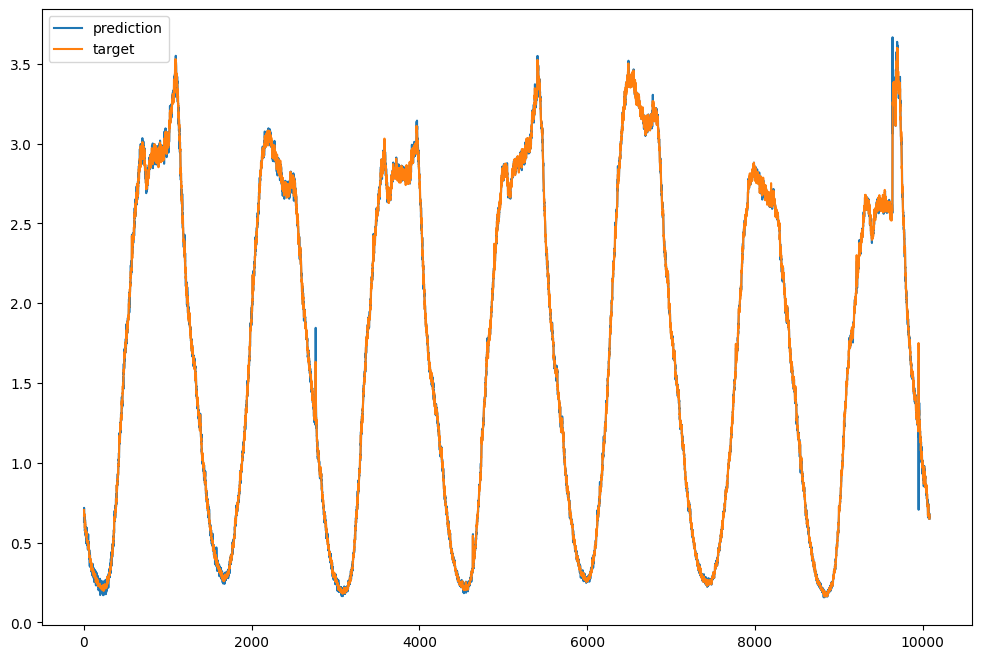

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.63059467, 0.71743512, 0.68772304, ..., 0.67163956, 0.6819334 ,
       0.6487413 ])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.704112],
       [0.689872],
       [0.666568],
       ...,
       [0.678984],
       [0.653888],
       [0.649888]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 1.8833423033356667 %
RMSE 0.03043229691684246
MAPE 1.8796272575855255 %


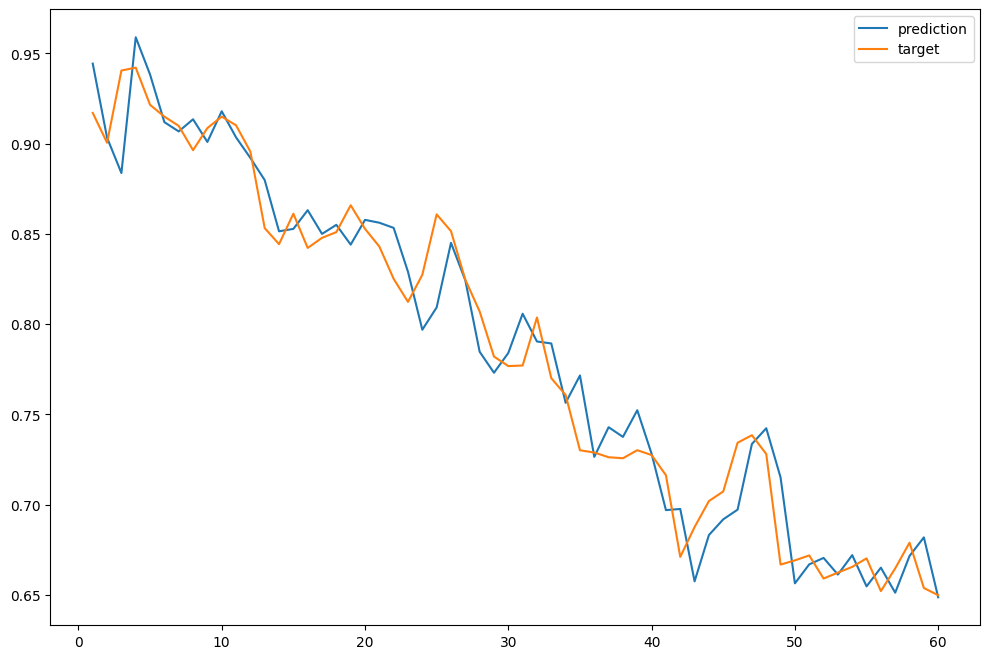

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.39821597290417504